In [ ]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
BASE_DIR = '/content/drive/MyDrive/cv_project_fall_2022/'
sys.path.append(BASE_DIR)


In [ ]:
import os
from os.path import abspath, expanduser

import torch
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets.utils  import download_and_extract_archive, download_file_from_google_drive, extract_archive, verify_str_arg
from torchvision.datasets import VisionDataset

import time
import numpy as np
from google.colab.patches import cv2_imshow
from typing import Any, Callable, Dict, List, Optional, Tuple, Union

import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Local libraries
from models.definitions.perceptual_loss_net import PerceptualLossNet
from models.definitions.transformer_net_new import TransformerNet
import utils.utils as utils



In [ ]:
# set this to true - to print the locations of files being used
verbose = True

class WIDERFace(VisionDataset):
    """`WIDERFace <http://shuoyang1213.me/WIDERFACE/>`_ Dataset.

    Args:
        root (string): Root directory where images and annotations are downloaded to.
            Expects the following folder structure if download=False:

            .. code::

                <root>
                    └── widerface
                        ├── wider_face_split ('wider_face_split.zip' if compressed)
                        ├── WIDER_train ('WIDER_train.zip' if compressed)
                        ├── WIDER_val ('WIDER_val.zip' if compressed)
                        └── WIDER_test ('WIDER_test.zip' if compressed)
        split (string): The dataset split to use. One of {``train``, ``val``, ``test``}.
            Defaults to ``train``.
        transform (callable, optional): A function/transform that  takes in a PIL image
            and returns a transformed version. E.g, ``transforms.RandomCrop``
        target_transform (callable, optional): A function/transform that takes in the
            target and transforms it.
        download (bool, optional): If true, downloads the dataset from the internet and
            puts it in root directory. If dataset is already downloaded, it is not
            downloaded again.

    """

    BASE_FOLDER = "widerface"
    FILE_LIST = [
        # File ID                             MD5 Hash                            Filename
        ("15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M", "3fedf70df600953d25982bcd13d91ba2", "WIDER_train.zip"),
        ("1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q", "dfa7d7e790efa35df3788964cf0bbaea", "WIDER_val.zip"),
        #("1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T", "e5d8f4248ed24c334bbd12f49c29dd40", "WIDER_test.zip"),
    ]
    ANNOTATIONS_FILE = (
        "http://shuoyang1213.me/WIDERFACE/support/bbx_annotation/wider_face_split.zip",
        "0e3767bcf0e326556d407bf5bff5d27c",
        "wider_face_split.zip",
    )

    def __init__(
        self,
        root: str,
        split: str = "train",
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        download: bool = False,
    ) -> None:
        super().__init__(
            root=os.path.join(root, self.BASE_FOLDER), transform=transform, target_transform=target_transform
        )
        # check arguments
        self.split = verify_str_arg(split, "split", ("train", "val", "test"))
        
        # Only load images with number of faces less than threshold
        self.face_count_threshold = 5
    
        if download:
            self.download()

        if not self._check_integrity():
            raise RuntimeError("Dataset not found or corrupted. You can use download=True to download and prepare it")

        self.img_info: List[Dict[str, Union[str, Dict[str, torch.Tensor]]]] = []
        if self.split in ("train", "val"):
            self.parse_train_val_annotations_file()
        else:
            self.parse_test_annotations_file()

        print("Dataset Size : ", len(self.img_info))

    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is a dict of annotations for all faces in the image.
            target=None for the test split.
        """

        # stay consistent with other datasets and return a PIL Image
        img = Image.open(self.img_info[index]["img_path"], mode='r')
        
        if self.transform is not None:
            img = self.transform(img)
        
        mask_path = self.img_info[index]["mask_path"]
        
        if verbose :
            print("Image Path : ", self.img_info[index]["img_path"])
            print("Mask Path : ", mask_path)
        
        face_mask = None
        if(os.path.exists(mask_path)):
            face_mask = Image.open(mask_path)

        target = None if self.split == "test" else face_mask

        if self.target_transform is not None and target is not None:
            target = self.target_transform(target)
        
        return img, target


    def __len__(self) -> int:
        return len(self.img_info)

    def extra_repr(self) -> str:
        lines = ["Split: {split}"]
        return "\n".join(lines).format(**self.__dict__)

    def parse_train_val_annotations_file(self) -> None:
        filename = "wider_face_train_bbx_gt.txt" if self.split == "train" else "wider_face_val_bbx_gt.txt"
        filepath = os.path.join(self.root, "wider_face_split", filename)

        with open(filepath) as f:
            lines = f.readlines()
            file_name_line, num_boxes_line, box_annotation_line = True, False, False
            num_boxes, box_counter = 0, 0
            labels = []
            for line in lines:
                line = line.rstrip()
                if file_name_line:
                    img_path = os.path.join(self.root, "WIDER_" + self.split, "images", line)
                    mask_path = os.path.join(self.root, "WIDER_" + self.split, "masks", line)
                    overlay_mask_path = os.path.join(self.root, "WIDER_" + self.split, "overlay_mask", line)
                    face_masked_image_path = os.path.join(self.root, "WIDER_" + self.split, "face_masked", line)
            
                    img_path = abspath(expanduser(img_path))
                    file_name_line = False
                    num_boxes_line = True
                elif num_boxes_line:
                    num_boxes = int(line)
                    num_boxes_line = False
                    box_annotation_line = True
                elif box_annotation_line:
                    box_counter += 1
                    line_split = line.split(" ")
                    line_values = [int(x) for x in line_split]
                    labels.append(line_values)
                    if box_counter >= num_boxes:
                        box_annotation_line = False
                        file_name_line = True
                        labels_tensor = torch.tensor(labels)
                        if num_boxes < self.face_count_threshold:
                            self.img_info.append(
                                {
                                    "img_path": img_path,
                                    "mask_path" : mask_path,
                                    "overlay_mask_path" : overlay_mask_path,
                                    "face_masked_image_path" : face_masked_image_path,
                                    "annotations": {
                                        "bbox": labels_tensor[:, 0:4],  # x, y, width, height
                                        "blur": labels_tensor[:, 4],
                                        "expression": labels_tensor[:, 5],
                                        "illumination": labels_tensor[:, 6],
                                        "occlusion": labels_tensor[:, 7],
                                        "pose": labels_tensor[:, 8],
                                        "invalid": labels_tensor[:, 9],
                                    },
                                }
                            )
                        box_counter = 0
                        labels.clear()
                else:
                    raise RuntimeError(f"Error parsing annotation file {filepath}")

    def parse_test_annotations_file(self) -> None:
        filepath = os.path.join(self.root, "wider_face_split", "wider_face_test_filelist.txt")
        filepath = abspath(expanduser(filepath))
        with open(filepath) as f:
            lines = f.readlines()
            for line in lines:
                line = line.rstrip()
                img_path = os.path.join(self.root, "WIDER_test", "images", line)
                img_path = abspath(expanduser(img_path))
                self.img_info.append({"img_path": img_path})

    def _check_integrity(self) -> bool:
        # Allow original archive to be deleted (zip). Only need the extracted images
        all_files = self.FILE_LIST.copy()
        all_files.append(self.ANNOTATIONS_FILE)
        for (_, md5, filename) in all_files:
            file, ext = os.path.splitext(filename)
            extracted_dir = os.path.join(self.root, file)
            if not os.path.exists(extracted_dir):
                print("extracted_dir : ", extracted_dir)
                return False
        return True

    def download(self) -> None:
        if self._check_integrity():
            print("Files already downloaded and verified")
            return

        # download and extract image data
        for (file_id, md5, filename) in self.FILE_LIST:
            download_file_from_google_drive(file_id, self.root, filename, md5)
            filepath = os.path.join(self.root, filename)
            extract_archive(filepath)

        # download and extract annotation files
        download_and_extract_archive(
            url=self.ANNOTATIONS_FILE[0], download_root=self.root, md5=self.ANNOTATIONS_FILE[1]
        )


In [ ]:
default_config = dict()

# Default Config

# Style image name that will be used for Styling in training
default_config['style_img_name'] = 'edtaonisl.jpg'

# Style image name that will be used for Styling Face in training
default_config['face_style_img_name'] = 'edtaonisl-blurred.jpg'

# Number of Epochs
default_config['num_of_epochs'] = 10

# Console log frequency - Number of batches before each log
default_config['console_log_freq'] = 10

# Checkpoint Save frequency - Number of batches before each save
default_config['checkpoint_freq'] = 100

# Content Loss Weight
default_config['content_weight'] = 1e0

# Style Loss Weight
default_config['style_weight'] = 4e5

# TV Loss Weight
default_config['tv_weight'] = 0


In [ ]:

# Wrapping training configuration into a dictionary
training_config = dict()
for arg in default_config.keys():
    training_config[arg] = default_config[arg]

root = BASE_DIR

# Style Image Path
training_config['style_images_path'] = os.path.join(BASE_DIR, 'data', 'style-images')

# Model Binaries Storage Path
training_config['model_binaries_path'] =  os.path.join(BASE_DIR, 'models', 'binaries')

# Checkpoint Storage Path
training_config['checkpoints_path'] = os.path.join(BASE_DIR, 'models', 'checkpoints')

# Training image resize dimentions - all dataset images are resized to (image_size x image_size)
training_config['image_size'] = 256

# Training batch size
training_config['batch_size'] = 4

# Dataset Root Dir
training_config['dataset_root_dir'] = BASE_DIR + "face_mask/data/"

# Face Edge Loss weight
training_config['face_edge_loss_weight'] = 1e5

In [ ]:
# Create Required Missing Directories
checkpoints_path = os.path.join(training_config['checkpoints_path'],default_config['style_img_name'].split('.')[0])
if default_config['checkpoint_freq'] is not None:
    os.makedirs(checkpoints_path, exist_ok=True)
# print(checkpoints_path)


## WiderFace Dataset Loader

In [ ]:
from torchvision import transforms
import numpy as np
from torch.utils.data import DataLoader


#Normalizing
WIDERFACE_MEAN_1 = np.array([0.485, 0.456, 0.406])
WIDERFACE_MEAN_255 = np.array([123.675, 116.28, 103.53])

# Usually when normalizing 0..255 images only mean-normalization is performed - that's why standard dev is all 1s here
WIDERFACE_STD_1 = np.array([0.229, 0.224, 0.225])
WIDERFACE_STD_NEUTRAL = np.array([1, 1, 1])




def get_training_data_loader(training_config, should_normalize=False, is_255_range=False):
    """
        There are multiple ways to make this feed-forward NST working,
        including using 0..255 range (without any normalization) images during transformer net training,
        keeping the options if somebody wants to play and get better results.
    """
    transform_list = [transforms.Resize(training_config['image_size']),
                      transforms.CenterCrop(training_config['image_size']),
                      transforms.ToTensor()]
    target_transform_list = [transforms.Resize(training_config['image_size']),
                      transforms.CenterCrop(training_config['image_size']),
                      transforms.Grayscale(),
                      transforms.ToTensor()]
    
    if is_255_range:
        transform_list.append(transforms.Lambda(lambda x: x.mul(255)))
    if should_normalize:
        transform_list.append(transforms.Normalize(mean=WIDERFACE_MEAN_255, std=WIDERFACE_STD_NEUTRAL) if is_255_range else transforms.Normalize(mean=WIDERFACE_MEAN_1, std=WIDERFACE_STD_1))
    
    transform = transforms.Compose(transform_list)
    target_transform = transforms.Compose(target_transform_list)

    
    dataset_train = WIDERFace(training_config['dataset_root_dir'], split="train", download=False, transform=transform,target_transform=target_transform)
    
    train_dataloader = DataLoader(dataset_train, batch_size=training_config['batch_size'], shuffle=True)
    print(f'Using {len(train_dataloader)*training_config["batch_size"]*training_config["num_of_epochs"]} datapoints ({len(train_dataloader)*training_config["num_of_epochs"]} batches) for transformer network training.')
    return train_dataloader


# Training Config

In [ ]:
training_config

{'style_img_name': 'edtaonisl.jpg',
 'face_style_img_name': 'edtaonisl-blurred.jpg',
 'num_of_epochs': 10,
 'console_log_freq': 10,
 'checkpoint_freq': 100,
 'content_weight': 1.0,
 'style_weight': 400000.0,
 'tv_weight': 0,
 'style_images_path': '/content/drive/MyDrive/cv_project_fall_2022/data/style-images',
 'model_binaries_path': '/content/drive/MyDrive/cv_project_fall_2022/models/binaries',
 'checkpoints_path': '/content/drive/MyDrive/cv_project_fall_2022/models/checkpoints',
 'image_size': 256,
 'batch_size': 4,
 'dataset_root_dir': '/content/drive/MyDrive/cv_project_fall_2022/face_mask/data/',
 'face_edge_loss_weight': 100000.0}

## Load Midas Model - We did not use this model for final results but was used in experimentation

In [ ]:
# Midas Model
# !pip install timm
# #model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
# #model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
# model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)
# midas = torch.hub.load("intel-isl/MiDaS", model_type)


# device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
# midas = midas.eval().to(device)

# # midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

# # if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
# #     midas_transforms = midas_transforms.dpt_transform
# # else:
# #     midas_transforms = midas_transforms.small_transform

# for param in midas.parameters():
#     param.requires_grad = False


## Load Edge Detection Model

In [ ]:
# HED Model - https://github.com/sniklaus/pytorch-hed
# from models.definitions.HED import HED

# RCF Model - https://github.com/yun-liu/RCF
# from models.definitions.RCF import RCF

# LDC Model - https://github.com/xavysp/LDC
from models.definitions.LDC import LDC

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
edge_model = LDC()
edge_model.to(device)
edge_model.eval()
edge_model_bin_path = BASE_DIR + "models/binaries/ldc/ldc.pth"
checkpoint = torch.load(edge_model_bin_path)
edge_model.load_state_dict(checkpoint)

for param in edge_model.parameters():
    param.requires_grad = False

In [ ]:

verbose = False
def train(training_config, load_checkpoint = None, check_point_name = 'ckpt_style_face_edge_only_ldc_pre_mask'):

    # Identify the device available for faster processing/training
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # prepare data loader
    train_loader = get_training_data_loader(training_config)

    # prepare neural networks
    transformer_net = TransformerNet().train().to(device)

    if(load_checkpoint is not None):
        training_state = torch.load(load_checkpoint)
        state_dict = training_state["state_dict"]
        transformer_net.load_state_dict(state_dict, strict=True)
        print("Loaded Check Point : ", load_checkpoint)

    # Create perceptual Loss Net
    perceptual_loss_net = PerceptualLossNet(requires_grad=False).to(device)

    # Define Optimizer
    optimizer = Adam(transformer_net.parameters())

    '''
    Calculate style image's and blurred-style image's Gram matrices (style representation)
    Built over feature maps as produced by the perceptual net - VGG16 
    '''

    
    # Style Image : Create gram matrix and Get loss features for style Image
    style_img_path = os.path.join(training_config['style_images_path'], training_config['style_img_name'])
    style_img = utils.prepare_img(style_img_path, target_shape=None, device=device, batch_size=training_config['batch_size'])
    style_img_set_of_feature_maps = perceptual_loss_net(style_img)
    target_style_representation = [utils.gram_matrix(x) for x in style_img_set_of_feature_maps]
    
    # Blurred Style Image : Create gram matrix and Get loss features for blurred style Image
    face_style_img_path = os.path.join(training_config['style_images_path'], training_config['face_style_img_name'])
    style_img_for_face = utils.prepare_img(style_img_path, target_shape=(training_config['image_size'],training_config['image_size']), device=device, batch_size=training_config['batch_size'])
    style_img_face_set_of_feature_maps = perceptual_loss_net(style_img_for_face)


    # Show Style Iamge
    image = Image.open(style_img_path)
    plt.imshow(image)
    plt.show()


    # Show Style Image for Face
    image = Image.open(face_style_img_path)
    plt.imshow(image)
    plt.show()
    
    # Layer from which the Face style loss feature is extracted - from perceptual loss network
    face_style_loss_layer = 1
    filter_size = 2 ** face_style_loss_layer
    
    # #   Print Training config header
    # utils.print_header(training_config)
    
    # Tracking loss metrics, Neural Style Transfer is ill-posed we can only track loss and visual appearance of the stylized images
    acc_content_loss, acc_style_loss, acc_depth_loss, acc_face_edge_loss, acc_content_face_loss, acc_style_face_loss, acc_tv_loss = [0., 0., 0., 0., 0., 0., 0.]

    # Make note of starting time - for logging and analysis
    ts = time.time()
    
    for epoch in range(training_config['num_of_epochs']):
        for batch_id, (content_batch, face_masked_image_batch) in enumerate(train_loader):

            # To skip the last batch with batch dimention mismatch because of 
            # number of data points not a multiple of batch size
            if(batch_id == 1980):
                break

            # Convert Content Batch and Face Mask to device
            content_batch = content_batch.to(device)
            face_masked_image_batch = face_masked_image_batch.to(device)
            
            # Create 4 channel Image with 4th channel being face masks in content image
            content_with_face_mask_batch = torch.cat([content_batch, face_masked_image_batch], dim=1).to(device)
            
            # Stylize the batch
            stylized_batch = transformer_net(content_with_face_mask_batch)
            
            
            '''
            We tried multiple loss metrices to :
                1. Image Content Loss - Preserve the content of source image
                2. Image Style Loss - Stylize the content image with source style 
                3. Face Content-Style Losses - Preserve specifically features of a face in an image and stylize at the same time
            '''
            
            content_batch_set_of_feature_maps = perceptual_loss_net(content_batch)
            stylized_batch_set_of_feature_maps = perceptual_loss_net(stylized_batch)

            ''' 1. Image Content Losses '''
            target_content_representation = content_batch_set_of_feature_maps.relu2_2
            current_content_representation = stylized_batch_set_of_feature_maps.relu2_2
            content_loss = training_config['content_weight'] * torch.nn.MSELoss(reduction='mean')(target_content_representation, current_content_representation)
            


            ''' 2. Image Style Losses '''
            style_loss = 0.0
            current_style_representation = [utils.gram_matrix(x) for x in stylized_batch_set_of_feature_maps]
            
            for gram_gt, gram_hat in zip(target_style_representation, current_style_representation):
                style_loss += torch.nn.MSELoss(reduction='mean')(gram_gt, gram_hat)
            style_loss /= len(target_style_representation)
            style_loss *= training_config['style_weight']

      
            ''' 3. Face Content-Style Losses '''
            
            
            ''' 3.1 Depth Loss - We did not use this Loss for final results but was used in experimentation - Hence [0]'''
            depth_loss = torch.tensor([0]).to(device)
            # content_depth_image = midas(content_batch)
            # styled_depth_image = midas(stylized_batch)
            # depth_loss  = training_config['structure_weight'] * training_config['depth_loss_weight'] * torch.nn.MSELoss(reduction='mean')(content_depth_image, styled_depth_image)
            

            
            ''' 3.2 Face Edge Loss '''
            content_face_masked = torch.mul(content_batch, face_masked_image_batch)
            styled_face_masked = torch.mul(stylized_batch, face_masked_image_batch)

            content_hed_face_masked = edge_model(content_face_masked)[0]
            styled_hed_face_masked = edge_model(styled_face_masked)[0]

            face_edge_loss  = training_config['face_edge_loss_weight'] * torch.nn.MSELoss(reduction='mean')(content_hed_face_masked, styled_hed_face_masked)

            '''
                Face Losses
                    1. Content Face Loss
                        a). Create masked features from output
                        b). Create masked features from content image
                        c). Compute loss
                    
                    2. Style Face Loss
                        a). Create masked style features from output
                        b). Make gram matrix from 1
                        c). Create masked style features from content image
                        d). Make gram matrix from 2
                        e). Compute loss
            '''
            ''' 3.3 Content Face Loss - We did not use this Loss for final results but was used in experimentation - Hence [0]'''
            content_loss_face =  torch.tensor([0]).to(device)
            stylized_face_masked_batch = torch.mul(stylized_batch, face_masked_image_batch)
            content_face_masked_image_batch = torch.mul(content_batch, face_masked_image_batch)
            content_loss_face = training_config['content_weight'] * torch.nn.MSELoss(reduction='mean')(content_face_masked_image_batch, stylized_face_masked_batch)

            ''' 3.4 Style Face Loss '''
            
            # Resize/blur mask to the dimentions of loss layer
            style_filter_mask = torch.nn.functional.avg_pool2d(face_masked_image_batch, filter_size, stride=filter_size, padding=0)

            # Mask the blurred style image loss feature map
            masked_features_content = torch.mul(style_img_face_set_of_feature_maps[face_style_loss_layer], style_filter_mask)
            face_style_representation = utils.gram_matrix(masked_features_content)

            
            # Mask the transformer net output image loss feature map
            masked_features_styled = torch.mul(stylized_batch_set_of_feature_maps[face_style_loss_layer], style_filter_mask)
            styled_face_style_representation = utils.gram_matrix(masked_features_styled)
        
            # Calculate Face Blurred-Style loss 
            style_loss_face = torch.nn.MSELoss(reduction='mean')(styled_face_style_representation, face_style_representation)
            style_loss_face *= training_config['style_weight']

            
            '''Calculate total variation loss - enforces image smoothness'''
            tv_loss = training_config['tv_weight'] * utils.total_variation(stylized_batch)
            
            # Compute Total Loss - Combines all losses
            total_loss = content_loss + style_loss + depth_loss + face_edge_loss + content_loss_face + style_loss_face  + tv_loss
            
            total_loss.backward()
            optimizer.step()

            # clear gradients for the next round
            optimizer.zero_grad()

            # Logging and checkpoint creation
            acc_content_loss += content_loss.item()
            acc_style_loss += style_loss.item()
            acc_depth_loss += depth_loss.item()
            acc_face_edge_loss += face_edge_loss.item()
            acc_content_face_loss += content_loss_face.item()
            acc_style_face_loss += style_loss_face.item()
            acc_tv_loss += tv_loss.item()

            if training_config['console_log_freq'] is not None and batch_id % training_config['console_log_freq'] == 0:
                print(f'time elapsed={(time.time()-ts)/60:.2f}[min]|epoch={epoch + 1}' +
                                                                 f'|batch=[{batch_id + 1}/{len(train_loader)}]' +
                                                                 f'|c-loss={acc_content_loss / training_config["console_log_freq"]}' +
                                                                 f'|s-loss={acc_style_loss / training_config["console_log_freq"]}' +
                                                                 f'|d-loss={acc_depth_loss / training_config["console_log_freq"]}' +
                                                                 f'|fe-loss={acc_face_edge_loss / training_config["console_log_freq"]}' +
                                                                 f'|cf-loss={acc_content_face_loss / training_config["console_log_freq"]}' +
                                                                 f'|sf-loss={acc_style_face_loss / training_config["console_log_freq"]}' +
                                                                 f'|tv-loss={acc_tv_loss / training_config["console_log_freq"]}' +
                                                                 f'|total loss={(acc_content_loss + acc_style_loss + acc_depth_loss  + acc_face_edge_loss + + acc_content_face_loss + acc_style_face_loss + acc_tv_loss) / training_config["console_log_freq"]}')
                ts = time.time()
                acc_content_loss, acc_style_loss, acc_depth_loss, acc_face_edge_loss, acc_content_face_loss, acc_style_face_loss, acc_tv_loss = [0., 0., 0., 0., 0., 0., 0.]

            if training_config['checkpoint_freq'] is not None and (batch_id + 1) % training_config['checkpoint_freq'] == 0:
                training_state = utils.get_training_metadata(training_config)
                training_state["state_dict"] = transformer_net.state_dict()
                training_state["optimizer_state"] = optimizer.state_dict()
                ckpt_model_name = f"{check_point_name}_{training_config['style_img_name'].split('.')[0]}_cw_{str(training_config['content_weight'])}_sw_{str(training_config['style_weight'])}_tw_{str(training_config['tv_weight'])}_epoch_{epoch}_batch_{batch_id}.pth"
                print("Saving checkpoint : ", os.path.join(training_config['checkpoints_path'], ckpt_model_name))
                torch.save(training_state, os.path.join(training_config['checkpoints_path'], ckpt_model_name))



edtaonisl-blurred-style-image-mask
Dataset Size :  7935
Using 79360 datapoints (19840 batches) for transformer network training.


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


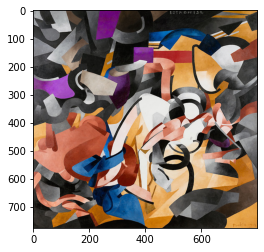

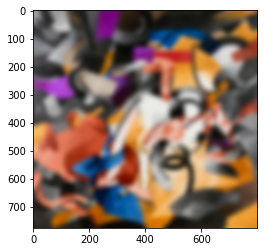

time elapsed=0.31[min]|epoch=1|batch=[1/1984]|c-loss=0.6660057067871094|s-loss=3.5577377319335937|d-loss=0.0|fe-loss=8.624313354492188|cf-loss=0.005049347877502441|sf-loss=0.33207776546478274|tv-loss=0.0|total loss=13.185183906555176
time elapsed=2.28[min]|epoch=1|batch=[11/1984]|c-loss=2.026653289794922|s-loss=78.85249118804931|d-loss=0.0|fe-loss=49.13571107387543|cf-loss=0.03361744869034737|sf-loss=1.9532243326306342|tv-loss=0.0|total loss=132.00169733304065
time elapsed=1.10[min]|epoch=1|batch=[21/1984]|c-loss=2.0522390723228456|s-loss=25.780007934570314|d-loss=0.0|fe-loss=11.663081777095794|cf-loss=0.01777384541928768|sf-loss=9.40567218363285|tv-loss=0.0|total loss=48.91877481304109
time elapsed=0.67[min]|epoch=1|batch=[31/1984]|c-loss=1.9564594745635986|s-loss=23.240973281860352|d-loss=0.0|fe-loss=6.573007428646088|cf-loss=0.013252067647408694|sf-loss=8.616146586835384|tv-loss=0.0|total loss=40.39983883955283
time elapsed=0.61[min]|epoch=1|batch=[41/1984]|c-loss=1.695765995979309|

In [ ]:
check_point_name = training_config['style_img_name'].split(".")[0] + "-blurred-style-image-mask"
print(check_point_name)
train(training_config, check_point_name=check_point_name)